# 이미지 생성 Image Generation
이번 노트북에서는 지난 시간에 이어 이미지 미분값에 대한 탐구를 계속한다.   
이번에도 TinyImageNet에 기 훈련된(pretrained)모델을 사용한다. 

이미지 생성을 위해 이 이미지 미분을 사용하는 여러 기법을 알아 볼 것이다.
구현할 내용은 다음과 같다.  
 - 클래스 시각화 (class visualizations)
 - 피쳐 역변환(feature inversion)
 - 딥 드림(DeepDream)

In [111]:
%%javascript
var fname = document.body.attributes['data-notebook-name'].value
var fpath = document.body.attributes['data-notebook-path'].value.replace(/^local/, '/root').replace(fname, '')
IPython.notebook.kernel.execute("theNoteBookDir = '" + fpath + "'" );

<IPython.core.display.Javascript object>

In [112]:
import os
os.chdir(theNoteBookDir)

In [113]:
# 언제나 처럼, 약간의 셋업이 필요하다

import time, os, json
import numpy as np
from scipy.misc import imread, imresize
import matplotlib.pyplot as plt

from cs231n.classifiers.pretrained_cnn import PretrainedCNN
from cs231n.data_utils                 import load_tiny_imagenet
from cs231n.image_utils                import blur_image, deprocess_image, preprocess_image

%matplotlib inline
plt.rcParams['figure.figsize']      = (10.0, 8.0)   # 플롯 크기 기본 값
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap']          = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# TinyImageNet 과 기 훈련된(pretrained) 모델
이전 노트북 처럼,  TinyImageNet 데이터셋과 기 훈련된 모델을 로드한다.

In [114]:
data  = load_tiny_imagenet('cs231n/datasets/tiny-imagenet-100-A', subtract_mean=True)
model = PretrainedCNN(h5_file='cs231n/datasets/pretrained_model.h5')

loading training data for synset 20 / 100
loading training data for synset 40 / 100
loading training data for synset 60 / 100
loading training data for synset 80 / 100
loading training data for synset 100 / 100


# 클래스 시각화

무작위 잡음 이미지를 시작점으로 해서 해당 클래스에 대한 기울기 상승 알고리즘을 수행한다. 이렇게 생성된 이미지 역시 해당 클래스로 인식될 것이다.  
이 아이디어는  논문 [1]에서 처음 소개되었다. 논문 [2]에서는 이 아이디어를 더 확장하였다. 그 논문에서는 정규화 기법을 제안해서 더 고퀄 이미지를 만들었다.  

---
#### 주요 기호
좀 더 구체적으로 설명하기 위해 기호를 정의하자,  
- $ I $ : 이미지 
- $ y $ : 타겟 클래스
- $ s_y(I) $ : 이미지 $I$ 를 CNN에 돌렸을 때 $y$ 클래스에 대응되는 스코어  
   이 스코어 값은 소프트맥스를 취하기 전의 값. 즉 정규화 되지 않은 값임을 유의하라.  
- $ I^* $ : 생성하고 싶은 이미지. 이 이미지는 클래스 $y$ 에 대해 매우 높은 스코어 값을 갖기를 원함. 
      
---  
####  최적화 문제로 접근하기
- 최적화 문제로 $I^*$ 값을 표현 할 수 있다.  
  $$ I^* = \arg\max_{I}  \{s_y(I) + R(I) \} $$  
- $R$ : (암시적으로 가능한  possibly implicit. 드롭아웃 류라고 보면 될 듯) 정규화 함수    
  (암시적 정규화 요소 적용의 일환으로) 이미지에 주기적으로 블러링 효과를 입힐 것이다.
- 우리는  논문[2] 에서 제안한 (암시적인) 정규화와 명시적인 L2 정규화와를 동시에 사용할 것이다.  
  $$Regularizatin\ \ Factor \ \ R(I) = IR(I) +  \lambda \|I\|_2^2 $$  
  단, $ IR(I) $ 는 암시적 정규화 요소.
  
- 최솟값이 아닌 최대값 문제이므로 기울기 하강이 아닌   
  기울기 상승 알고리즘으로 위의 최적화 문제를 풀 수 있다.  
  
--- 

#### 미분값 계산.  
오브젝티브 함수의 기울기를 알려면  [생성하려는(즉, 찾으려는) 이미지에 대한 ]미분값을 계산하면 된다.  
- $Objective(I) =   s_y(I) + R(I) =  s_y(I) + IR(I) +  \lambda \|I\|_2^2 $  이므로   
  벡터 I에 대해 미분을 해 보면 다음과 같다.(dK 는 dK/dI 편미분 값을 약식 표기한 것)     
  $dOjbective(I) =  ds_y(I) + dIR(I) +  2 * \lambda * I $  
- 미분 계산 코드 구현 
  - $ ds_y(I) $ 는 스코어를 구하는 함와 대응되는 backpropataion함수에 dout값 1 을 주어 계산하면 되지만 
    여기서는 조작된 dscore값을 사용한다. (위의 cs21n 슬라이드 참조)
  - $ dIR(I) $ 는 블러링이나 지터 같은 암시적인 정규화 요소라서 수식으로 구하지 않는다.   
  - $ d \lambda \|I\|_2^2 $ =  $ 2* \lambda *I $  인데  (식을 유도하고 코딩하기가 어려울 수 있으나)   
    이미 assignment #1 부터 다루고 있었다.    
    assignment1/cs231n/classifiers/neural_net.py 등의 loss함수에서 dW 구하는 부분 구현 참조하면 된다. 
                   
---
#### ToDo: 아래 셀의  `create_class_visualization` 함수 구현을 완성하라.

---
#### 참고
- 논문[1]: Karen Simonyan, Andrea Vedaldi, and Andrew Zisserman.   
  "Deep Inside Convolutional Networks: Visualising Image Classification Models and Saliency Maps",  ICLR Workshop 2014.

- 논문[2]: Yosinski et al,  
  "Understanding Neural Networks Through Deep Visualization", ICML 2015 Deep Learning Workshop

- cs231n: Lecture 9.  ![image](https://cloud.githubusercontent.com/assets/1628848/20622587/f51f2e58-b346-11e6-80ab-0a03cc43e33f.png)

In [121]:
def create_class_visualization(target_y, model, **kwargs):
    """
    Perform optimization over the image to generate class visualizations.
    클래스 시각화를 위해서 해당 이미지에 대한 최적화를 수행.
      
    입력:
      - target_y: [0, 100) 범위의 정수. 타켓 클래스를 의미.
      - model   : 기 훈련된 CNN 모델, 이미지 생성에 사용함.  
      -  kwargs 인자값 (kwargs := keywords arguments)
          - learning_rate  : 경사 하강 계수 learning rate (float)
          - blur_every     : 이미지에 대한 블러 정규화 빈도(integer)
          - l2_reg         : 이미지에 대한 L2   정규화 강도. 위 최적화 수식에서의 λ값 (float)
          - max_jitter     : 무작위 지터(jitter) 강도. 이미지 전처리 정규화 성분.
          - num_iterations : run 수행 반복횟수
          - show_every     : 이미지 보여주는 빈도. 매 show_every 이터레이션마다 보여 줌.
      
    출력:
      - X : 생성된 이미지 (1, 3, 64, 64)
    """
                               # 패러미터 이름,   기본값
    learning_rate  = kwargs.pop('learning_rate',  10000)
    blur_every     = kwargs.pop('blur_every',     1)
    l2_reg         = kwargs.pop('l2_reg',         1e-6)
    max_jitter     = kwargs.pop('max_jitter',     4)
    num_iterations = kwargs.pop('num_iterations', 100)
    show_every     = kwargs.pop('show_every',     25)
  
    X = np.random.randn(1, 3, 64, 64)
    for t in xrange(num_iterations):        
        # 정규화를 위해, 무작위 지터를 이미지에 수행한다.
        #    구간 [-max_jitter, max_jitter+1) 에서 2개의 값을 꺼낸다. 
        ox, oy = np.random.randint(-max_jitter, max_jitter+1, 2) 
        #    ox 만큼  height 방향으로 r-rotate, oy 만큼 width 방향으로 r-rotate 시킨다.  
        X = np.roll(np.roll(X, ox, -1), oy, -2)

        dX = None
        ############################################################################
        # TODO: target_y 클래스 스코에 대한  이미지 미분값 dX 를 계산하라.         #
        # 저번 시간에 했던 '거짓 이미지' 와 유사하다.                              #
        # 단, L2 정규화 값을 dX에 더한 후에,                                       #
        # learning_rate를 이용해서 이미지 x를 업데이트 하라.                       #
        ############################################################################
        
        # 1. 스코어 부분 미분값 dsy 구하기. 
        score,  cache = model.forward(X)  
        dscore        = np.zeros_like(score)        # (1, 100)               
        dscore[0, target_y] = 1        
        dsy  = model.backward(dscore, cache)[0]
        
        # 2.  L2 정규화 부분 미분값 dL2R 구하기
        dL2R = 2 * l2_reg * X
        
        # 3. 오브젝티브 함수 전체에 대한 미분 값 구하기. 
        dX   = dsy + dL2R
        
        # 4. 이미지에 미분값 (양의 방향으로) 더하기
        X   += dX * learning_rate               
        ############################################################################
        #                            작성한 코드 끝                                #
        ############################################################################
    
        # 지터효과를 다시 복원시킨다. 
        X = np.roll(np.roll(X, -ox, -1), -oy, -2)
    
        # 정규화를 위해, 이미지를 자른다
        X = np.clip(X, -data['mean_image'], 255.0 - data['mean_image'])
    
        # 정규화를 위해, 주기적으로 블러 효과를 적용한다.
        if (t+1) % blur_every == 0:
            X = blur_image(X)
    
        # 주기적으로 중간 이미지를 그린다.
        if (t+1) % show_every == 0:
            print 'iter:', t+1, '/', num_iterations
            plt.imshow(deprocess_image(X, data['mean_image']))
            plt.gcf().set_size_inches(3, 3)
            plt.axis('off')
            plt.show()
    return X

위의 코드를 이용하면 아티슥한 이미지 생성이 가능하다!   
아래 예제를 통해 생성해 보자.
Yosinski et al  논문[2]에서 제안한 다른 정규화 방법을 시도해 볼 수 있지만 안 해 봐도 된다.

['tarantula']
default  parameter:
iter: 25 / 100


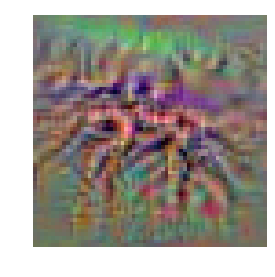

iter: 50 / 100


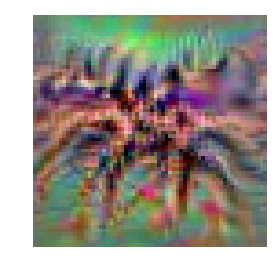

iter: 75 / 100


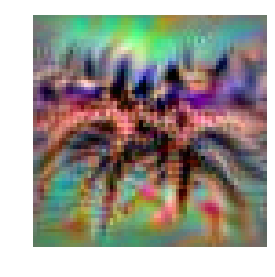

iter: 100 / 100


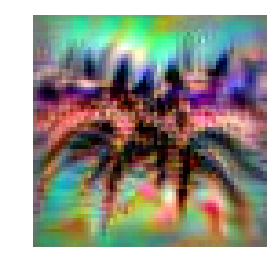

jitter = off:
iter: 100 / 100


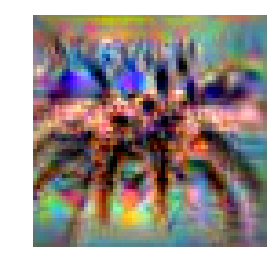

blur = off:
iter: 100 / 100


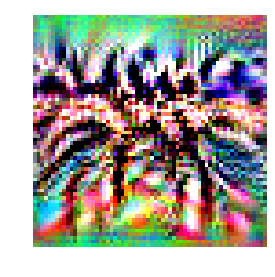

learning_rate /=2 , num_iteration *= 2:
iter: 200 / 200


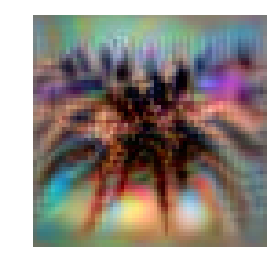

learning_rate /=2 , num_iteration *= 2, jitter /=2:
iter: 200 / 200


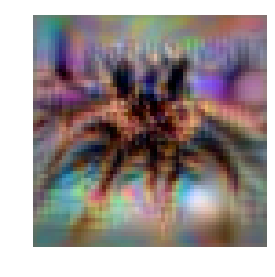

learning_rate /=2 , num_iteration *= 2, jitter /=2, bulr/= 2:
iter: 200 / 200


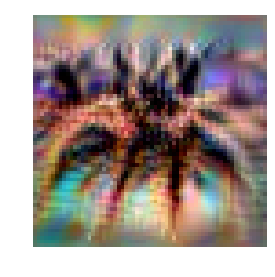

In [120]:
target_y = 43 # 타란툴라(독거미의 일종)
print data['class_names'][target_y]
visualize = lambda  **param : create_class_visualization(target_y, model, **param)

print '====================\ndefault  parameter:'
X = visualize(show_every = 25)

print '=====================\njitter = off:'
X = visualize(show_every = 100, max_jitter = 0)

print '=====================\nblur = off:'
X = visualize( show_every = 100, blur_every = 101)

print '=====================\nlearning_rate /=2 , num_iteration *= 2:'
X = visualize(show_every = 200, num_iterations = 200, learning_rate = 5000)

print '=====================\nlearning_rate /=2 , num_iteration *= 2, jitter /=2:'
X = visualize(show_every = 200, num_iterations = 200, learning_rate = 5000, max_jitter = 2)

print '=====================\nlearning_rate /=2 , num_iteration *= 2, jitter /=2, bulr/= 2:'
X = visualize(show_every = 200, num_iterations = 200, learning_rate = 5000, max_jitter = 2, blur_every = 2)

# 피처로 그림 만들기: Feature Inversion
CNN이 인식을 위해 학습한 피처 타입을 이해하기 위한 시도가 있었다.  최근 논문 [1] 에서는 피처 표현으로부터 이미지를 재구성했다. 이 아이디어는 기 학습된 모델로 이미지 미분값을 구하는 방식으로 쉽게 구현된다. 
 
---

#### 주요 기호  
- $I_y$ : 타겟 입력 이미지,   
- $\phi_\ell(I)$ : CNN $\phi$ 에서의 $\ell$  번째  활성 레이어 (피처들)
- $I^*$  : 생성하고 싶은 이미지. $\phi$ 모델에서 $\ell$  번째 활성 레이어 피처 표현값이 $\phi_\ell(I_y)$ 와 유사한 이미지.

---
#### 최적화 문제로 접근하기.

- 최적화 문제로 $I^*$  를 표현할 수 있다.   $$ I^* = \arg\min_{I} \|\phi_\ell(I_y) - \phi_\ell(I)\|_2^2 + R(I) $$ 
- $ \|\cdot\|_2^2 $ 은 L2 유클리디안 거리를 나타낸다.
- 이전 처럼 $R$ 은  (암시적인) 정규화 요소이다.  
  (암시적 정규화 요소 적용의 일환으로)  논문 [2]에서 제안한 방법인 이미지에 주기적으로 블러링 효과 입히기를 적용한다.  
  아래와 같이 (명시적인) L2 정규화 항도 사용할 것이다.
  $$ Regularizatin \ \ Factor \ \ R(I) =  IR(I) + \lambda * \|I\|_2^2 $$ 
  단, $ IR(I) $ 는 암시적 정규화 요소.
- 이번에도 역시 이 최적화 문제를 기울기 하강(정확히는 상승) 알고리즘으로 풀 수 있다.  
  생성된 이미지에 대한 미분값을 사용해서 기울기를 구한다.  

---
#### 미분값 계산  
오브젝티브 함수의 기울기를 알려면  [생성하려는(즉, 찾으려는) 이미지에 대한 ]미분값을 계산하면 된다.
- 오브젝티브 함수의 [생성하려는(즉, 찾으려는) 이미지에 대한 ]미분값을 계산하면 된다.
  - $Objective(I) =   \|\phi_\ell(I_y) - \phi_\ell(I)\|_2^2 + R(I) $  
   $ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ =  \|\phi_\ell(I_y) - \phi_\ell(I)\|_2^2 + IR(I) + \lambda \|I\|_2^2 $$  $ 이므로   
    벡터 I에 대해 미분을 해 보면 다음과 같다.($d(\ K\ ) $ 는 dK/dI 편미분 값을 약식 표기한 것)     
    $ d(\ Ojbective(I)\ ) =  -2 * (\phi_\ell(I_y) - \phi_\ell(I)) * d(\ \phi_\ell(I)\ ) + d)\ IR(I)\ ) +  2 * \lambda \|I\|_2 $    
  - $ d(\ \|\phi_\ell(I_y) - \phi_\ell(I)\|_2^2\ )  = 2 * (\phi_\ell(I_y) - \phi_\ell(I)) * d(\ \phi_\ell(I)\ ) $ 임을 보이기가 좀 어려울 수 있다.

- 미분 계산 코드 구현 
  - $ \phi_\ell(I) $ 값 구하는 forward 함수에 대응되는 backpropataion 함수의 dout 자리에   
    $ -2 * (\phi_\ell(I_y) - \phi_\ell(I))$  를 넣어서 계산하면  
    체인룰에 의해 $  -2 * (\phi_\ell(I_y) - \phi_\ell(I)) * d(\ \phi_\ell(I)\ ) $ 를 구할 수 있다. 
  - $ d(\ IR(I)\ )$ 는 블러링이나 지터 같은 암시적인 정규화 요소라서 수식으로 구하지 않는다.   
  - $ d(\ \lambda \|I\|_2^2 \ ) $ =  $ 2* \lambda *I $  인데  (식을 유도하고 코딩하기가 어려울 수 있으나) 이미 위에서 했 보았다.
--- 

##### ToDo: 아래 셀의 invert_features 함수 구현을 완성하라

---
#### 참고
- 논문 [1]: Aravindh Mahendran, Andrea Vedaldi, "Understanding Deep Image Representations by Inverting them", CVPR 2015

- 논문 [2]: Yosinski et al, "Understanding Neural Networks Through Deep Visualization", ICML 2015 Deep Learning Workshop

In [206]:
def invert_features(target_feats, layer, model, **kwargs):
    """
    논문 'Mahendran and Vedaldi 2015'방식에 따라 피처로 그림 만들기를 한다.
    정규화는 L2 정규화와 주기적인 블러링을 사용한다. 
    
    입력:
      - target_feats: 타겟 이미지의 피처맵들.  (1, C, H, W);
                      이 타겟 이미지 피처맵들에 매칭되는 이미지 생성을 시도한다.
      - layer       : 타겟 이미지 피처들이 뽑혀진 레이어.
      - model       : 기 학습된 CNN. 이 모델로 타겟 피처들을 뽑았다.
      - **kwargs 인자값. (kwargs := keywords arguments)
          - learning_rate : 경사 하강 계수. 
          - num_iterations: 경사 하강 적용 반복 횟수
          - l2_reg        : L2 정규화 강도. 위의 수식에서의 람다 값.
          - blur_every    : 이미지에 대한 블러 정규화 빈도; 블러링 효과를 비활성화 시키려면 0으로 설정한다.
          - show_every    : 이미지 보여주는 빈도. 매 show_every 이터레이션마다 보여 줌. 중간 이미지 볼 필요 없으면 0 으로 설정한다.
    
    출력:
      - X: 입력 받은 target features 에 매치되도록 생성한 이미지. (1, 3, 64, 64) 
    """
    learning_rate  = kwargs.pop('learning_rate',  10000)
    num_iterations = kwargs.pop('num_iterations', 500)
    l2_reg         = kwargs.pop('l2_reg',         1e-7)
    blur_every     = kwargs.pop('blur_every',     1)
    show_every     = kwargs.pop('show_every',     50)
  
    X = np.random.randn(1, 3, 64, 64)
    for t in xrange(num_iterations):
        ############################################################################
        # 할일:                                                                    # 
        # 1. 이미지 X 재구성 부분에 대한 이미지 미분값 dX 를 계산하라.             #
        # 2. l2_reg 패러미터 값을 갖는 L2 정규화를 적용해야 한다.                  #
        #    생성되는 이미지가 큰 수치의 픽셀값을 덜 갖도록 유도할 것이다.         #
        # 3. 입력 받은 learning_rate 과 위에서 구한 값을 곱해서                    #
        #    이미지 X를  업데이트 한다.                                            #
        ############################################################################
        # 0.  피처의 차이 구하기
        now_feats, cache = model.forward(X, end = layer)
        diff_feats       = target_feats - now_feats
    
        # 1. 피처의 차이 부분에 대한 dX 구하기.
        #     1.1 dout 구하기
        dout   = -2 * diff_feats
        #     1.2 피처의 차이 부분에 대한 dX 구하기
        dX, _  = model.backward(dout, cache)
    
        # 2. L2 정규화에 대한 dX 구하기.
        dX +=  2 * l2_reg * X
    
        # 3. 기울기 dX로 이미지 업데이트 하기.
        X -= dX * learning_rate    
    
        ############################################################################
        #                            작성한 코드 끝                                #
        ############################################################################
    
        # 정규화 요소로, 이미지 값을 클리핑 한다.
        X = np.clip(X, -data['mean_image'], 255.0 - data['mean_image'])
    
        # 정규화 요소로, 주기적으로 이미지를 블러링한다.
        if (blur_every > 0) and t % blur_every == 0:
            X = blur_image(X)

        # ★★★ t 값 처리 로직 코드를 변경시켰다. ★★★  
        if (show_every > 0) and ((t+1) % show_every == 0):
            plt.imshow(deprocess_image(X, data['mean_image']))
            plt.gcf().set_size_inches(3, 3)
            plt.axis('off')
            plt.title('t = %d/%d' %(t+1, num_iterations))
            plt.show()
            
    # ★★★생성된 그림을 리턴하도록 코드 추가했다. ★★★ 
    return deprocess_image(X, data['mean_image'])

### 피처들로 재구성하기 : 얕은 버전
아래 셀에서는 기 훈련된 모델의  4번째 컨벌루션 레이어의 피처를 이용해 재구성 한다.
위 셀에서 구현한 feature inversion 을 이용할 것이다. 
구현을 제대로 했다면 아래 셀에서 지정한 하이퍼 파라미터 값으로 재구성이 가능할 것이다.

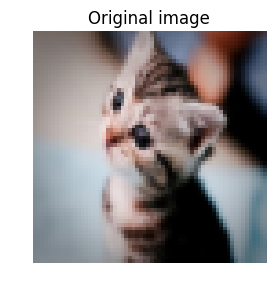

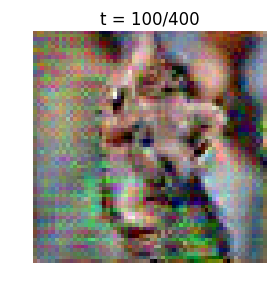

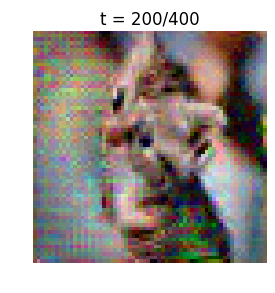

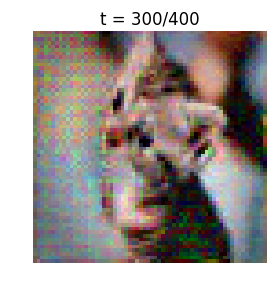

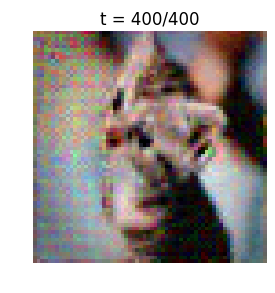

In [211]:
filename = 'kitten.jpg'
layer = 3 # 레이어는 제로 인덱싱이라 컨볼루션을 4번 수행한 후의 피처맵들을 뽑는다.

img = imresize(imread(filename), (64, 64))

plt.imshow(img)
plt.gcf().set_size_inches(3, 3)
plt.title('Original image')
plt.axis('off')
plt.show()

# 네트워크에 태우기 전에 전처리를 한다:
# 평균 훈련 데이터 이미지를 빼 주고, [배치 입력폼으로 맞추도록]차원도 추가하고 등등등
img_pre = preprocess_image(img, data['mean_image'])

# 이미지에 대한 피처맵들을 추출한다.
feats, _ = model.forward(img_pre, end=layer)


# 피처들을 역전파 시켜 그림 생성
kwargs = {
  'num_iterations': 400,
  'learning_rate': 5000,
  'l2_reg': 1e-8,
  'show_every': 100,
  'blur_every': 10,
}
X = invert_features(feats, layer, model, **kwargs)

### 피처들로 재구성하기 : 깊은 버전
 
더 깊은 레이어의 피처를 이용해 재구성을 하면 보다 흥미로워지는 경향이 있다.
아래 셀 구현을 통해 가장 좋은 이미지를 재구성해 보라.
7번재 컨벌루션 레이어의 피처를 이용해야 한다.
좋은 결과를 얻기 위해서는 하이퍼 파라미터를 만져야 한다.

힌트: 참고 논문 [1]에 나왔듯이, 피처 뽑는 레이어가 깊어질 수록 재구성된 이미지는 원래 이미지와 유사도가 낮아지게 된다.  
위에서 한 것처럼 비슷한 이미지가 나올 거라 기대하지 말아야 한다.  
어렴풋이 알아볼 만한 구조를 갖는 그림을 1000 반복안에 찾을 수 있어야 한다.

l2_reg: 1e-8


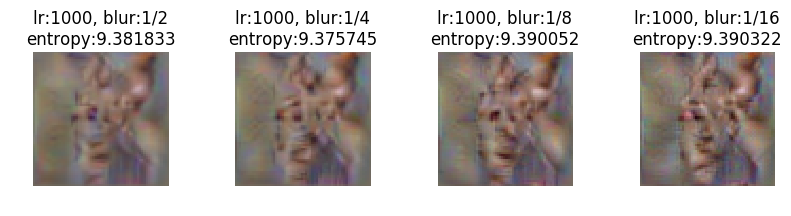

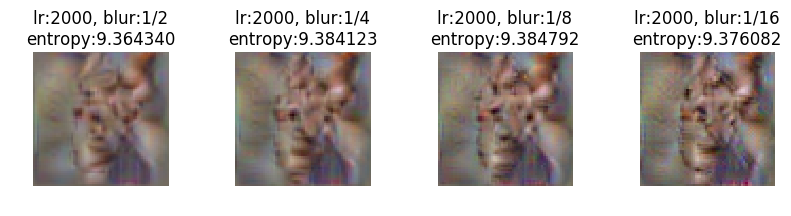

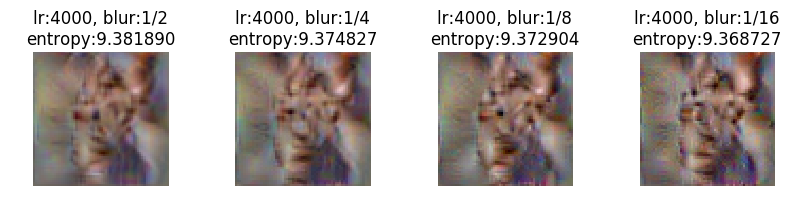

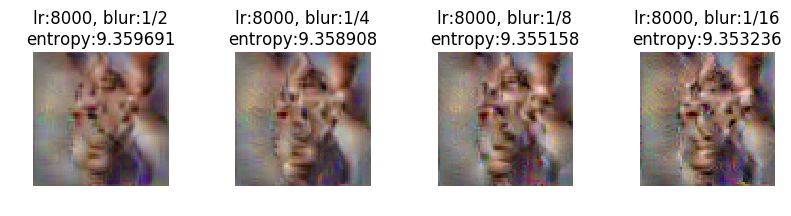

blur every : 8


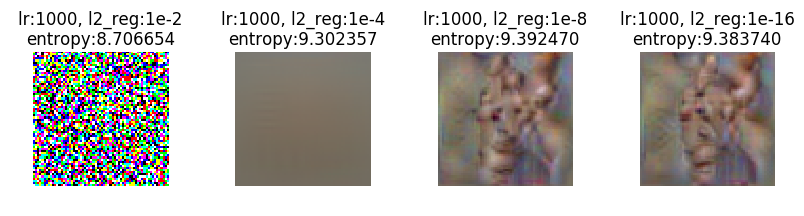

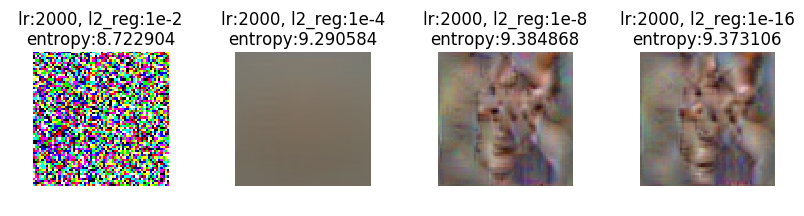

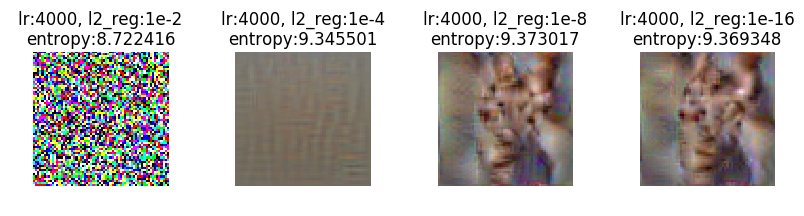

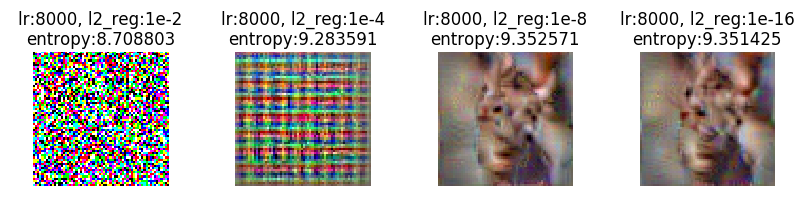

In [246]:
filename = 'kitten.jpg'
layer    = 5    # 레이어는 제로 인덱싱이라 컨볼루션을 7 번 수행한 후의 피처맵들을 뽑는다.
img      = imresize(imread(filename), (64, 64))

# 네트워크에 태우기 전에 전처리를 한다:
# 평균 훈련 데이터 이미지를 빼 주고, [배치 입력폼으로 맞추도록]차원도 추가하고 등등등
img_pre  = preprocess_image(img, data['mean_image'])

# 이미지에 대한 피처맵들을 추출한다.
feats, _ = model.forward(img_pre, end=layer)


def invert(lr, l2_reg, blur):
    # 피처들을 역전파 시켜 그림 생성
    # 아래 하이퍼 파라미터들을 만져 줘야 한다.
    kwargs = {
      'num_iterations': 1000,
      'learning_rate':  lr,
      'l2_reg':         l2_reg,
      'show_every':     0,
      'blur_every':     blur,
    }
    return invert_features(feats, layer, model, **kwargs)

def entropy(X):
    import scipy
    X = X - np.min(X) # 모두 양수로
    return scipy.stats.entropy(X.flatten())

# 일단 눈으로 직접 패턴을 보기 위해 랜덤 서치가 아니라 그리드 서치를 했다.
params = np.array(
         [[(1000, 2), (1000, 4), (1000, 8), (1000, 16)],
          [(2000, 2), (2000, 4), (2000, 8), (2000, 16)],
          [(4000, 2), (4000, 4), (4000, 8), (4000, 16)],
          [(8000, 2), (8000, 4), (8000, 8), (8000, 16)]])
print '===================================================================='
print 'l2_reg: 1e-8'

for i in xrange(4):
    for j in xrange(4):
        lr, blur = params[i][j]
        
        X = invert(lr, 1e-8, blur) 
        
        plt.subplot(4, 4, i*4+j+1)
        plt.title('lr:%d, blur:1/%d\nentropy:%f'%(lr,blur, entropy(X)))
        plt.imshow(X.astype('uint8'))
        plt.axis('off')        
    plt.show()  

print '===================================================================='
print 'blur every : 8'

for i in xrange(4):
    for j in xrange(4):
        lr, l2 = params[i][j]
        l2_reg = 1./(10**l2)
        
        X = invert(lr, l2_reg, 8) 
        
        plt.subplot(4, 4, i*4+j+1)
        plt.title('lr:%d, l2_reg:1e-%d\nentropy:%f'%(lr, l2, entropy(X)))
        plt.imshow(X.astype('uint8'))
        plt.axis('off')        
    plt.show()



# 딥 드림: DeepDream
2015년 여름, 구글은 블로그 하나를 발표했다 ([blog post](http://googleresearch.blogspot.com/2015/06/inceptionism-going-deeper-into-neural.html)). 
뉴럴 네트워크로부터 그림을 생성하는 내용이었다. 얼마 후에는 코드도 공개했다 ([released code](https://github.com/google/deepdream) ).  

아이디어는 매우 간단하다.  
네트워크에서 레이어 몇 개를 고른다. 이미지를  네트워크에 통과시키고 해당 레이어들에서 피처들을 골라낸다.  
해당 레이어서의 미분값을 activation값과 같도록 설정한다. 
설정된 미분값을 이미지로 역전파 시킨다. 해당 레이어의 activation 값이 증폭되는 효과가 나타난다.


딥드림 에서는  일반적으로 컨벌루션 레이어로부터 피처를 추출한다. 생성하고자 하는 이미지의 해상도 제약은 없다.

지금까지 사용한 기 훈련된 네트워크로 딥드림 구현이 가능하다. 결과는 구글 보단 못 할 것이다. 구글의 네트워크는 우리보다 훨씬 크다. 하지만 우리 네트워크로도 흥미로운 그림을 그릴 수 있다.

In [243]:
def deepdream(X, layer, model, **kwargs):
    """
    딥드림 이미지 생성
  
    입력:
      - X    : 시작 이미지.(1, 3, H, W)
      - layer: 꿈을 꿀 레이어
      - model: 기 훈련된 CNN
      - **kwargs 인자값. (kwargs := keywords arguments)
          - learning_rate : 경사 하강 계수. 
          - num_iterations: 반복 횟수
          - max_jitter    :jitter 정규화를 위한 픽셀 최대값.
          - show_every    : 이미지 보여주는 빈도. 매 show_every 이터레이션마다 보여 줌.
    """
  
    X = X.copy()
  
    learning_rate  = kwargs.pop('learning_rate', 5.0)
    max_jitter     = kwargs.pop('max_jitter', 16)
    num_iterations = kwargs.pop('num_iterations', 100)
    show_every     = kwargs.pop('show_every', 25)
  
    for t in xrange(num_iterations):
        # 정규화 요소로, 무작위 지터를 이미지에 더해 준다.
        ox, oy = np.random.randint(-max_jitter, max_jitter+1, 2)
        X = np.roll(np.roll(X, ox, -1), oy, -2)

        dX = None
        ############################################################################
        # 할일:                                                                    #
        #   딥드림으로 이미지 미분값  dX를 구한다.                                 #
        #   입력 받은 CNN의 forward 와 backward 맴버 함수를 이용해                 #
        #   [선택된 레이어의] 활성 맵을 미분값 dX로 설정한다.                      #
        #   dX 를 이미지 X 에 업데이트 할 때 learnig rate 곱해서 더해야 한다.      #
        ############################################################################
        feats, cache = model.forward(X, end = layer)
        dX, _        = model.backward(feats, cache)
        X            += dX*learning_rate
        ############################################################################
        #                         작성한 코드 끝                                   #
        ############################################################################
    
        # 지터 효과를 되돌린다.
        X = np.roll(np.roll(X, -ox, -1), -oy, -2)
    
        # 정규화 요소로, 픽셀 값을 클리핑 한다.
        mean_pixel = data['mean_image'].mean(axis=(1, 2), keepdims=True)
        X = np.clip(X, -mean_pixel, 255.0 - mean_pixel)
    
        # 주기적으로 중간 이미지를 보여 준다.
        if t == 0 or (t + 1) % show_every == 0:
            img = deprocess_image(X, data['mean_image'], mean='pixel')
            plt.imshow(img)
            plt.title('t = %d' % (t + 1))
            plt.gcf().set_size_inches(8, 8)
            plt.axis('off')
            plt.show()
    return X

# 그려보자. Generate some images!

기 훈련된 네트워크를 이용해 쿨해 보이는 딥드림 그림을 그려보자.  
여러 레이어를 그려보려고 시도해 볼 수 있다. 시작 레이어를 바꿔 볼 수도 있다.  
너무 느린 환경이면 이미지 크기를 줄여 보라.  
뭔가 멋진 그림을 그릴 수 있을 것 같은 느낌이 들면 이미지 크기를 늘려 보라.  

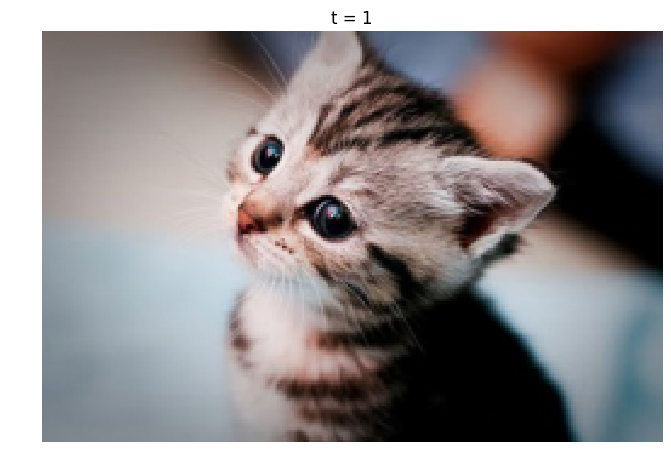

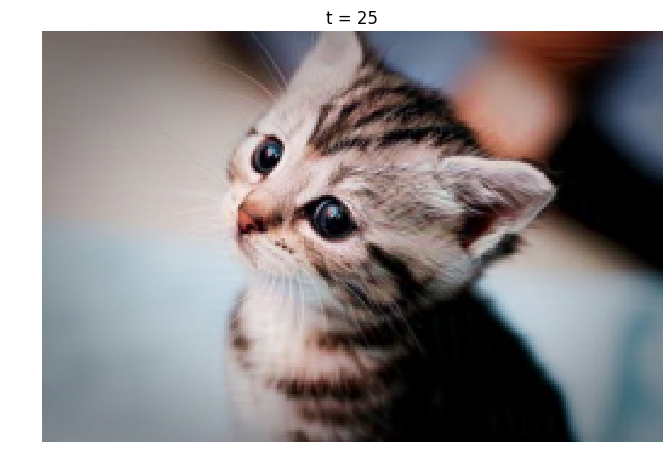

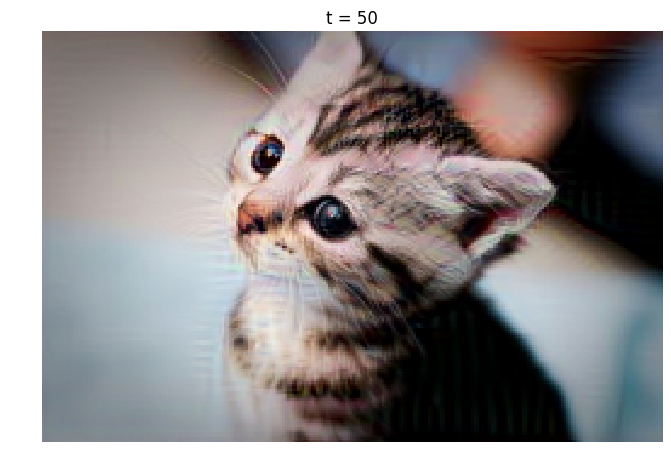

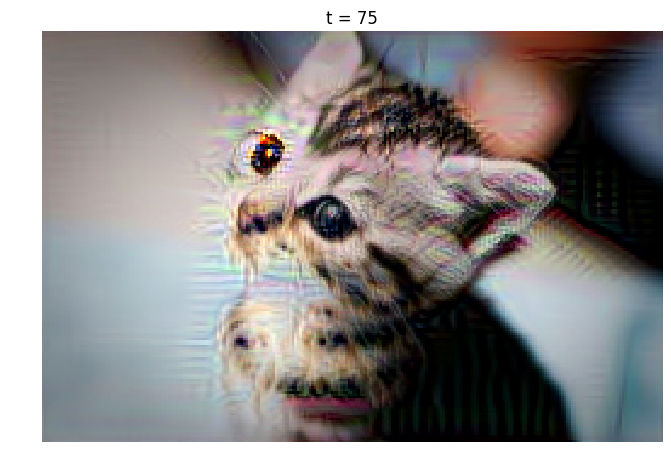

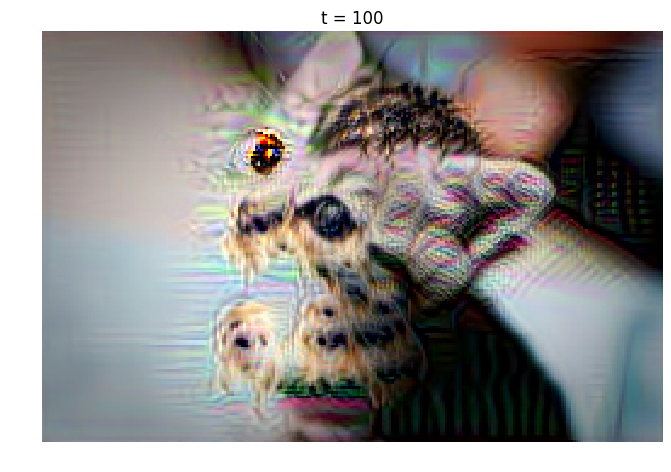

In [244]:
def read_image(filename, max_size):
    """
    디스크에서 이미지를 읽어서
    더 긴 쪽이 max 사이즈가 되도록 확대/축소를 한다.
    """
    img = imread(filename)
    H, W, _ = img.shape
    if H >= W:
        img = imresize(img, (max_size, int(W * float(max_size) / H)))
    elif H < W:
        img = imresize(img, (int(H * float(max_size) / W), max_size))
    return img

filename = 'kitten.jpg'
max_size = 256
img = read_image(filename, max_size)
plt.imshow(img)
plt.axis('off')

# 전처리를 한다. 
# 픽셀 값이 float값을 갖도록 타입 변환, transposing, 평균값 빼기...
img_pre = preprocess_image(img, data['mean_image'], mean='pixel')

out = deepdream(img_pre, 7, model, learning_rate=2000)